In [3]:
from xpinn import XPINN
import jax.numpy as np
from utils import data_path

data_path = data_path / "NavierStokes"

n_boundary = 400
n_interior = 2100

file_train = data_path /f"laminar_decomp_train_{n_boundary}_{n_interior}.json"
file_test = data_path / "test.json"

activation = np.tanh
xpinn = XPINN(file_train, activation)

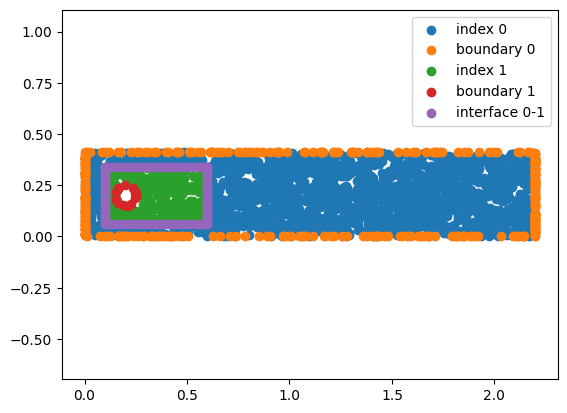

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.axis("equal"
)

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

In [5]:
from typing import Callable
from type_util import Params, Array
from base_network import neural_network
from jax import hessian, jit, vmap, grad, jacobian
import jax.numpy as np

LFunc = Callable[[Params, dict[str, Array]], Array]

model = neural_network(activation)
v_model = vmap(model, (None, 0))

#### Advection term

In [6]:
psi = lambda params, xy: model(params, xy)[0]

hess_psi = hessian(psi, argnums=1)
d_psi_dxy = grad(psi, argnums=1)

def advection_term(params: Params, xy: Array) -> Array:
    hess = hess_psi(params, xy)
    processed_hess = np.array([[-hess[1, 1], hess[0, 1]], [hess[1, 0], -hess[0, 0]]])
    return processed_hess @ d_psi_dxy(params, xy)



#### Diffusion term

In [7]:
jacobi_hess_psi = jacobian(hess_psi, argnums=1)

def diffusion_term(params: Params, xy: Array):
    jachessi = jacobi_hess_psi(params, xy)
    u_diffusion = jachessi[0,1,0] + jachessi[1,1,1] #psi_yxx + psi_yyy
    v_diffusion = jachessi[1,0,1] + jachessi[0,0,0] #psi_xyy + psi_xxx
    return np.array([u_diffusion, -v_diffusion])

#### Pressure

In [8]:
p = lambda params, xy: model(params, xy)[1]

d_p = grad(p, argnums=1)

#### Navier stokes residual

In [9]:
def navier_stokes_residual_factory(index: int, nu:float, weight : int = 1) -> LFunc:

    def residual(params, xy):
        return advection_term(params, xy) - nu* diffusion_term(params, xy) + d_p(params, xy)

    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual
    
    def interior_loss(params: Params, points: dict[str, Array]) -> Array:
        pts = points["interior"]
        return weight * 2 * np.mean(v_residual(params, pts) ** 2)
    
    return interior_loss

#### Inflow

In [10]:
U = 0.3
inflow_func = lambda xy: np.array((4 * U * xy[1] * (0.41 - xy[1])/(0.41**2), 0.0))

In [11]:
def uv(params: Params, xy: Array) -> Array:
    d_psi = d_psi_dxy(params, xy)
    u = d_psi[1]
    v = -d_psi[0]
    return np.array([u, v])

#### Boundary Losses
One of the PINNs has the cylinder and the other has the remainding boundaries. 
vmap throws an error if it gets a empty array, so we need two different
boundary losses 

In [12]:
def cylinder_boundary_loss_factory(weight: int = 1) -> LFunc:
    
    def wall_boundary_loss(params, xy):
        return np.sum(np.square(uv(params, xy))) #return u**2 + v**2
    
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:

        cylinder_pts = points['cylinder boundary']
        
        cylinder = v_wall_boundary_loss(params, cylinder_pts)
    
        return np.mean(cylinder)*weight
    
    return boundary_loss

In [13]:
from typing import Tuple

def boundary_loss_factory_no_cylinder(inflow_func: Callable[[Array], Array], nu:float, weights:Tuple[int, int, int]= (1,1,1) ) -> LFunc:
    
    def left_boundary_loss(params, xy):
        return np.sum(np.square(uv(params, xy) - inflow_func(xy))) #(u - inflow)**2 + v**2
        
    def right_boundary_loss(params, xy):
        u_ = hess_psi(params, xy)[:,1]
        u_x = u_[0]
        u_y = u_[1]
        return (nu * u_x - p(params, xy)) ** 2 + (nu * u_y) ** 2
        
    def wall_boundary_loss(params, xy):
        return np.sum(np.square(uv(params, xy))) #return u**2 + v**2
    
    v_wall_boundary_loss = vmap(wall_boundary_loss, (None, 0))
    v_left_boundary_loss = vmap(left_boundary_loss, (None, 0))
    v_right_boundary_loss = vmap(right_boundary_loss, (None, 0))
    
    def boundary_loss(params: Params, points: dict[str, Array]) -> Array:

        left_pts = points['left boundary']
        right_pts = points['right boundary']
        wall_pts = points['wall boundary']
    
        left = np.mean(v_left_boundary_loss(params, left_pts)) * weights[0]
        right = np.mean(v_right_boundary_loss(params, right_pts)) * weights[1]
        wall = np.mean(v_wall_boundary_loss(params, wall_pts)) * weights[2]
    
        return left + right + wall
    
    return boundary_loss

#### Interface loss

In [14]:
def interface_loss_factory(i: int, j: int, weight = 1) -> LFunc:
    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]
        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return weight * (res_ij + avg_ij)

    return interface_loss

In [15]:
p0 = xpinn.PINNs[0]
p0.boundary_loss = boundary_loss_factory_no_cylinder(inflow_func, 0.001, (20,1,1))
p0.interior_loss = navier_stokes_residual_factory(0, 0.001, 1)


p1 = xpinn.PINNs[1]
p1.interior_loss = navier_stokes_residual_factory(1, 0.001, 30)
p1.boundary_loss = cylinder_boundary_loss_factory(weight = 1)

p0.interface_loss = interface_loss_factory(0, 1, weight = 20)
p1.interface_loss = interface_loss_factory(1, 0, weight = 20)

p0.create_loss()
p1.create_loss()

<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x147b14400>>

In [16]:
import optax

shapes = [[2] + 10 * [20] + [2], [2] + [30] * 20 + [2]]

exponential_decay = optax.exponential_decay(
    init_value=0.001,
    transition_steps=2000,
    transition_begin=2000,
    decay_rate=0.1,
    end_value=0.00001
)

optimizer = optax.adam(learning_rate=exponential_decay)

xpinn.initialize_params(shapes, optimizer)

/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:24: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return scale * random.normal(
/Users/junmiaohu/Documents/UiO/FYS5429/FYS5429/Project1XPINNs/src/base_network.py:26: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  ), scale * random.normal(b_key, (n,), dtype=np.float64)


In [17]:
print("Starting iterations")
n_iter = 6000
losses = xpinn.run_iters(n_iter)

2024-04-01 22:06:45.538748: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update_iteration] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
from utils import model_path\

our_model_path = model_path / "NavierStokes"/ "Decomp"/ "laminar" / f"ADAM_{n_iter}_iter_7layer_JUNMIAO"
xpinn.save_model(our_model_path)


NameError: name 'n_iter' is not defined